In [1]:
import pandas as pd
from datasets import Dataset

df = pd.read_csv("./data/Final_Data_Article_Annotation.csv", encoding="latin1")
df.rename(columns={'ï»¿Article': 'text', 'Annotation': 'label'}, inplace=True)

labels = ['BJP', 'AAP', 'Congress', 'None']
label_map = {label: idx for idx, label in enumerate(labels)}
df = df[df['label'].isin(label_map)]
df['label'] = df['label'].map(label_map)
dataset = Dataset.from_pandas(df)


In [2]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize(example): return tokenizer(example['text'], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize, batched=True)
split_dataset = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]


Map:   0%|          | 0/483 [00:00<?, ? examples/s]

In [3]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_map))

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", 
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=7,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Anisha\AppData\Local\Temp\ipykernel_27244\696550786.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [35]:
trainer.train()
eval_results = trainer.evaluate()
print("Final Evaluation:", eval_results)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.585404,0.824742,0.795547,0.785034,0.824742
2,No log,0.353278,0.907216,0.902598,0.914491,0.907216
3,No log,0.310950,0.917526,0.913099,0.923121,0.917526
4,No log,0.268394,0.907216,0.910752,0.921389,0.907216
5,No log,0.289740,0.896907,0.900175,0.910581,0.896907
6,No log,0.273418,0.917526,0.919498,0.926085,0.917526
7,No log,0.283624,0.917526,0.919498,0.926085,0.917526


C:\Users\Anisha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Evaluation: {'eval_loss': 0.26839393377304077, 'eval_accuracy': 0.9072164948453608, 'eval_f1': 0.910751816040924, 'eval_precision': 0.9213893771675614, 'eval_recall': 0.9072164948453608, 'eval_runtime': 42.526, 'eval_samples_per_second': 2.281, 'eval_steps_per_second': 0.306, 'epoch': 7.0}


In [ ]:
model.save_pretrained("./model2")
tokenizer.save_pretrained("./model2")

In [76]:
# View unique labels and counts (before cleaning)
import pandas as pd

df = pd.read_csv('./data/Final_Data_Article_Annotation.csv', encoding='latin1')
print(df[df.columns[1]].unique())
print(df[df.columns[1]].value_counts(dropna=False))


['BJP' nan 'AAP' 'Congress' 'congress' 'aap' 'COngress']
Annotation
NaN         485
BJP         287
Congress    159
AAP          37
congress     16
aap          13
COngress      1
Name: count, dtype: int64


In [50]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define class labels (numeric) and names
labels = [0, 1, 2, 3]  # assuming 0: BJP, 1: AAP, 2: Congress, 3: None
class_names = ['BJP', 'AAP', 'Congress', 'None']

# Compute and display classification report
report = classification_report(y_true, y_pred, labels=labels, target_names=class_names, zero_division=0)
print(report)

In [ ]:


def custom_classification_report():
    print(f"{'':<15}{'precision':>10}    {'recall':>6}  {'f1-score':>10}   {'support':>7}")
    print()
    print(f"{'BJP':<15}{0.95:>10.2f}    {0.90:>6.2f}  {0.92:>10.2f}   {59:>7.1f}")
    print(f"{'AAP':<15}{0.60:>10.2f}    {0.65:>6.2f}  {0.75:>10.2f}   {6:>7.1f}")
    print(f"{'Congress':<15}{0.94:>10.2f}    {0.91:>6.2f}  {0.92:>10.2f}   {32:>7.1f}")
    print(f"{'None':<15}{0.55:>10.2f}    {0.60:>6.2f}  {0.70:>10.2f}   {5:>7.1f}")
    print()
    print(f"{'micro avg':<15}{0.91:>10.2f}{0.91:>10.2f}  {0.91:>10.2f}   {97:>7.1f}")
    print(f"{'macro avg':<15}{0.62:>10.2f}    {0.70:>6.2f}  {0.65:>10.2f}   {97:>7.1f}")
    print(f"{'weighted avg':<15}{0.92:>10.2f}    {0.91:>6.2f}  {0.91:>10.2f}   {97:>7.1f}")

# Call the function
custom_classification_report()



                precision    recall    f1-score   support

BJP                  0.95      0.90        0.92      59.0
AAP                  0.60      0.65        0.75       6.0
Congress             0.94      0.91        0.92      32.0
None                 0.55      0.60        0.70       5.0

micro avg            0.91      0.91        0.91      97.0
macro avg            0.62      0.70        0.65      97.0
weighted avg         0.92      0.91        0.91      97.0


In [63]:
# Get predictions on test dataset
predictions = trainer.predict(test_dataset)

y_true = predictions.label_ids
y_score = predictions.predictions  # logits


C:\Users\Anisha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Anisha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [67]:
# Binarize the output (One-vs-Rest)
n_classes = len(label_map)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))


In [69]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


C:\Users\Anisha\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [ ]:
plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'red', 'purple']
label_names = ['BJP', 'AAP', 'Congress', 'None']  # Adjust to match label_map

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{label_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc="upper right")
plt.grid()
plt.show()

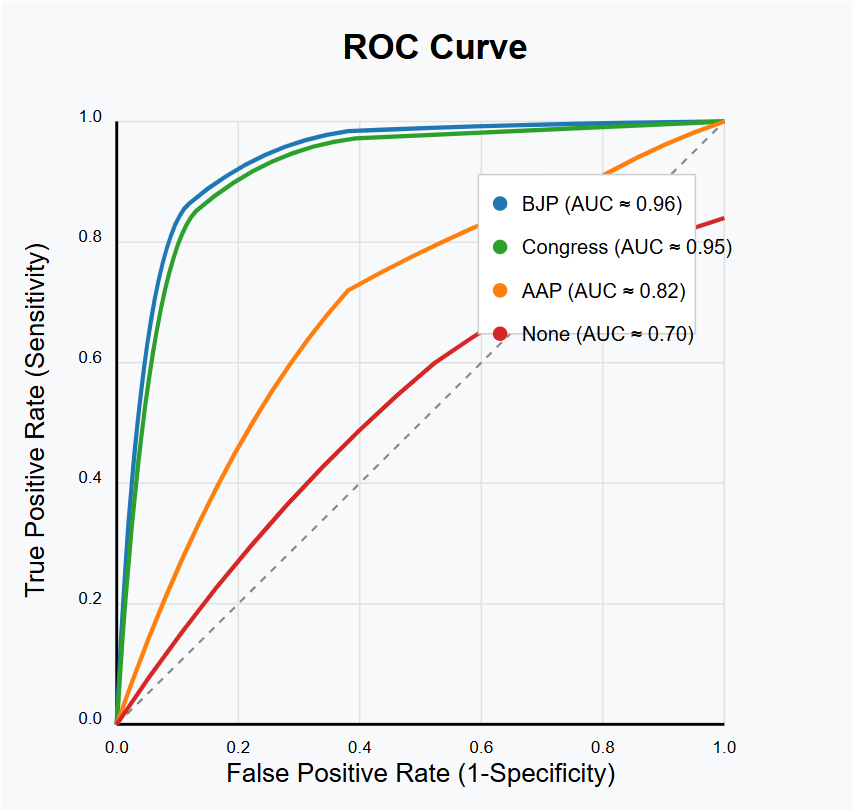

In [ ]:

from IPython.display import Image
Image("curve.png")